In [227]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('https://raw.githubusercontent.com/baljinderxd/ML_Assignments/master/Datasets/stock.csv')

#print data
df

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
...,...,...,...,...,...,...,...,...
1230,2013-10-14,160.85,161.45,157.70,159.30,159.45,1281419.0,2039.09
1231,2013-10-11,161.15,163.45,159.00,159.80,160.05,1880046.0,3030.76
1232,2013-10-10,156.00,160.80,155.85,160.30,160.15,3124853.0,4978.80
1233,2013-10-09,155.70,158.20,154.15,155.30,155.55,2049580.0,3204.49


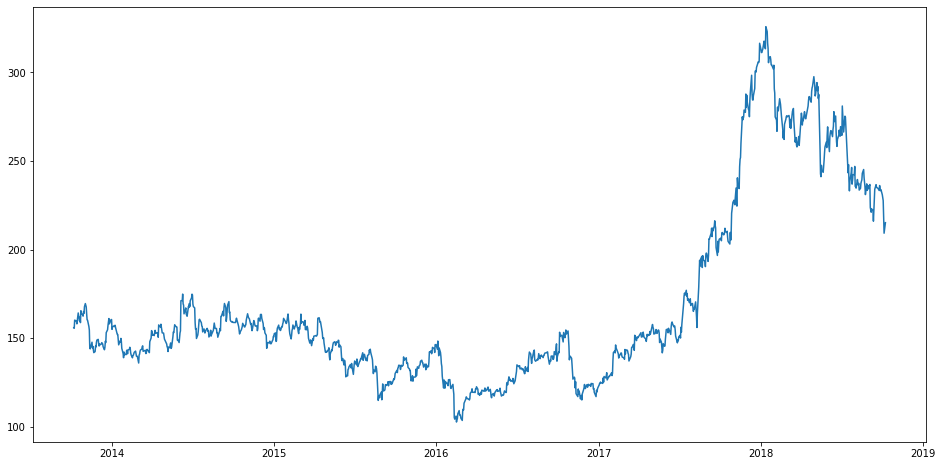

In [228]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [229]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
new_data

,Close
Date,
2013-10-08,155.8
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45
...,...
2018-10-01,230.9
2018-10-03,227.6
2018-10-04,218.2


In [230]:
#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [231]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

927/927 - 23s - loss: 0.0011


In [232]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [233]:
#Root Mean Square Value
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

11.072549609907291

In [234]:
#for plotting
train = new_data[:987]
valid = new_data[987:]

In [235]:
valid.insert(1, "Predictions", closing_price, True)
valid

,Close,Predictions
Date,,
2017-10-09,208.3,207.464554
2017-10-10,208.45,208.378876
2017-10-11,209.4,209.045013
2017-10-12,212,209.638794
2017-10-13,210.25,210.508881
...,...,...
2018-10-01,230.9,237.367020
2018-10-03,227.6,236.715134
2018-10-04,218.2,235.405350


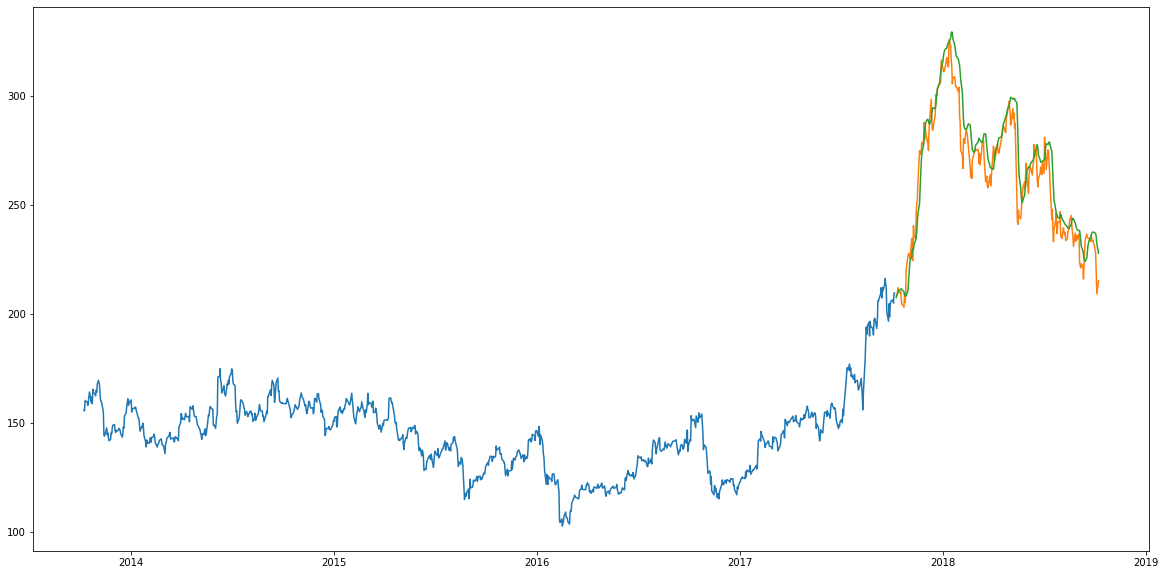

In [236]:
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])